In [1]:
import os
import onnx
import torch

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
print("Model dir:", model_dir)
torch.set_num_threads(2)

Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie


In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 737.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 7.6 MB/s eta 0:00:00


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset: DDD

In [5]:
# OPTIONAL: download Driver Drowsiness Dataset (DDD) from Kaggle
# This requires that you have the Kaggle API configured inside your environment.
# If it fails, you can instead download and unzip manually into data/DDD.

!mkdir -p data
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd -p data --force
# https://www.kaggle.com/datasets/esrakavalci/sust-ddd?utm_source=chatgpt.com
# https://www.kaggle.com/datasets/yasharjebraeily/drowsy-detection-dataset?utm_source=chatgpt.com
!ls data

Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown
 97%|█████████████████████████████████████▉ | 2.51G/2.58G [00:04<00:00, 523MB/s]
100%|███████████████████████████████████████| 2.58G/2.58G [00:05<00:00, 515MB/s]
DDD_raw  driver-drowsiness-dataset-ddd.zip


In [6]:
!unzip -oq data/driver-drowsiness-dataset-ddd.zip -d data/DDD_raw
print("Unzip completed.")

Unzip completed.


In [1]:
# Dataset: UTA-RLDD

In [5]:
!mkdir -p data_uta_rldd
!kaggle datasets download -d minhngt02/uta-rldd -p data_uta_rldd --force
!ls data_uta_rldd

Dataset URL: https://www.kaggle.com/datasets/minhngt02/uta-rldd
License(s): CC0-1.0
 99%|██████████████████████████████████████▊| 2.76G/2.77G [00:06<00:00, 448MB/s]
100%|███████████████████████████████████████| 2.77G/2.77G [00:07<00:00, 411MB/s]
UTA_RLDD_raw  uta-rldd.zip


In [6]:
!unzip -oq data_uta_rldd/uta-rldd.zip -d data_uta_rldd/UTA_RLDD_raw
print("Unzip completed.")

Unzip completed.


In [7]:
# import torch
# from torch.utils.data import Dataset
# from tqdm import tqdm

# class CachedDataset(Dataset):
#     def __init__(self, base_dataset):
#         self.data = []
#         self.targets = []

#         # keep metadata from ImageFolder
#         self.classes = base_dataset.classes
#         self.class_to_idx = base_dataset.class_to_idx
#         self.samples = base_dataset.samples

#         print("Caching dataset into RAM...")
#         for img, label in tqdm(base_dataset):
#             self.data.append(img)      # tensor after transforms
#             self.targets.append(label)
#         print("Caching done. Total samples:", len(self.data))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.targets[idx]


In [ ]:
# Initialize Dataset DDD

In [117]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# Root folder where the DDD images live
ddd_root = "data/DDD_raw/Driver Drowsiness Dataset (DDD)"

# Image transform: resize to 256x256, to tensor
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),   # (3, 256, 256), float32 in [0,1]
# ])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# Full dataset (no caching now!)
full_dataset = ImageFolder(root=ddd_root, transform=transform)

# Split into train / test
train_ratio = 0.6
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size

train_quantized_dataset, test_quantized_dataset = random_split(
    full_dataset, [train_size, test_size]
)

print("Total samples:", len(full_dataset))
print("Train samples:", len(train_quantized_dataset))
print("Test  samples:", len(test_quantized_dataset))

# Inspect one sample
x0, y0 = train_quantized_dataset[0]
print("Shape of one input sample:", x0.shape)   # (3, 256, 256)
print("Example label index:", y0)
print("Class names:", full_dataset.classes)



Total samples: 41793
Train samples: 25075
Test  samples: 16718
Shape of one input sample: torch.Size([3, 128, 128])
Example label index: 0
Class names: ['Drowsy', 'Non Drowsy']


In [ ]:
# Initialize Dataset URA-RLDD

In [25]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

# -------------------------------------------------------
# 1. Root folder where you unzipped the UTA-RLDD Kaggle dataset
#    Adjust this path to match your environment.
# -------------------------------------------------------
uta_root = "data_uta_rldd/UTA_RLDD_raw"   # <-- change if needed

train_root = os.path.join(uta_root, "train")
val_root   = os.path.join(uta_root, "val")
test_root  = os.path.join(uta_root, "test")

# -------------------------------------------------------
# 2. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# 2) No augmentation, only resize + normalize: VAL/TEST
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5]),
# ])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

full_dataset = ImageFolder(root= os.path.join(uta_root, "train") , transform=transform)
# -------------------------------------------------------
# 3. Build train / val / test datasets from folders
# -------------------------------------------------------
train_quantized_dataset = ImageFolder(root=train_root, transform=transform)
val_quantized_dataset   = ImageFolder(root=val_root,   transform=eval_transform)
test_quantized_dataset  = ImageFolder(root=test_root,  transform=eval_transform)

print("Classes:", train_quantized_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", train_quantized_dataset.classes[y0])
print("Class names:", full_dataset.classes)

Classes: ['active', 'fatigue']
Train images: 9054
Val   images: 1824
Test  images: 909
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: active
Class names: ['active', 'fatigue']


Random TRAIN sample:


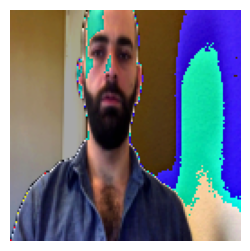

Title: Train sample
Label index: 0
--------------------------------------------------
Random TEST sample:


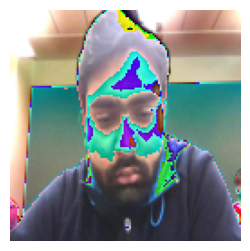

Title: Test sample
Label index: 1
--------------------------------------------------


In [26]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_random_sample_from_subset(subset, title):
    # subset is a torch.utils.data.Subset
    # subset.dataset is the underlying ImageFolder
    # subset.indices is the list of indices into the ImageFolder

    # pick a random index inside the subset
    subset_idx = random.randint(0, len(subset) - 1)
    # real_idx = subset.indices[subset_idx]   # index inside ImageFolder

    # get image + label
    img, label = subset[subset_idx]

    # get file path
    # filepath, _ = subset.dataset.samples[real_idx]

    # convert tensor to PIL for display
    img_pil = F.to_pil_image(img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_pil)
    # plt.title(f"{title}\nLabel: {subset.dataset.classes[label]}")
    plt.axis("off")
    plt.show()

    # also print details in text
    print(f"Title: {title}")
    print(f"Label index: {label}")
    # print(f"Label name: {subset.dataset.classes[label]}")
    # print(f"File path: {filepath}")
    print("--------------------------------------------------")


print("Random TRAIN sample:")
show_random_sample_from_subset(train_quantized_dataset, "Train sample")

print("Random TEST sample:")
show_random_sample_from_subset(test_quantized_dataset, "Test sample")


In [ ]:
# Various Parameters

In [27]:
from torch.utils.data import DataLoader

batch_size = 16   # safer for larger images; adjust later if needed

train_quantized_loader = DataLoader(
    train_quantized_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # try 4; reduce to 0 if errors
    pin_memory=False
)

test_quantized_loader = DataLoader(
    test_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

val_quantized_loader = DataLoader(
    val_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [28]:
count = 0
for x, y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break


Input shape for 1 batch: torch.Size([16, 3, 128, 128])
Label shape for 1 batch: torch.Size([16])


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


In [30]:
# Hyperparameters for the quantized CNN

# Quantization:
#  - 2-bit weights: small, good for FPGA
#  - 4-bit activations: more resolution than MNIST demo, still efficient
weight_bit_width = 4
act_bit_width = 4 

# Number of output classes for DDD (Drowsy / Non Drowsy)
# full_dataset.classes comes from the ImageFolder you created earlier
num_classes = len(full_dataset.classes)   # should be 2

print("Weight bit-width:", weight_bit_width)
print("Activation bit-width:", act_bit_width)
print("Number of classes:", num_classes, "->", full_dataset.classes)


Weight bit-width: 4
Activation bit-width: 4
Number of classes: 2 -> ['active', 'fatigue']


In [ ]:
# Neural Network Architectures

In [62]:
#### MODEL 6 #### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN(nn.Module):
    """
    Lighter version of the Keras-style model:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.5) -> Dense(32) -> Dense(num_classes)
    """

    def __init__(self, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # --------- Block 1: 3 -> 16 ---------
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # H,W: 128 -> 64

        # --------- Block 2: 16 -> 32 ---------
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64 -> 32

        # --------- Block 3: 32 -> 32 ---------
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32 -> 16

        # --------- Block 4: 32 -> 32 ---------
        self.conv4 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)   # 16 -> 8

        # --------- Compute feature_dim automatically ---------
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]   # should be 32 * 8 * 8 = 2048 for 128x128

        # --------- Dropout + FC layers ---------
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=32,   # smaller hidden layer
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=32,
            out_features=num_classes,   # 2 for drowsy/active
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)   # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)             # logits
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

model = SmallKerasLikeQuantCNN(
    num_classes=num_classes,
    w_bit=weight_bit_width,
    a_bit=act_bit_width,
    input_height=input_h,
    input_width=input_w,
).to(device)

print(model)
print("feature_dim:", model.feature_dim)

SmallKerasLikeQuantCNN(
  (conv1): QuantConv2d(
    3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_sc

In [32]:
#############################
######## MODEL 6.1 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_1(nn.Module):
    """
    Model 6.1:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        # feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # for 128: 32*8*8 = 2048

        # Head
        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

model = SmallKerasLikeQuantCNN_6_1(
    num_classes=num_classes,
    w_bit=weight_bit_width,
    a_bit=act_bit_width,
    input_height=128,
    input_width=128
).to(device)

print(model)
print("feature_dim:", model.feature_dim)


SmallKerasLikeQuantCNN_6_1(
  (conv1): QuantConv2d(
    3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stat

In [44]:
#############################
######## MODEL 6.2 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_2(nn.Module):
    """
    Model 6.2:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(48) + MaxPool
      Conv(64) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 48, 32 -> 16
        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 48 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(48, 64, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 64*8*8 = 4096

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

model = SmallKerasLikeQuantCNN_6_2(
    num_classes=num_classes,
    w_bit=weight_bit_width,
    a_bit=act_bit_width,
    input_height=128,
    input_width=128
).to(device)

print(model)
print("feature_dim:", model.feature_dim)


SmallKerasLikeQuantCNN_6_2(
  (conv1): QuantConv2d(
    3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stat

In [54]:
#############################
######## MODEL 6.3 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_3(nn.Module):
    """
    Model 6.3:
      Same as Model 6 conv widths, but adds Dropout2d(p=0.1) in the conv trunk
      (training-only) + head like 6.1.
    """

    def __init__(self, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout2d in trunk (training-only)
        self.drop2 = nn.Dropout2d(p=0.1)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop3 = nn.Dropout2d(p=0.1)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.drop2(x)
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.drop3(x)
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

model = SmallKerasLikeQuantCNN_6_3(
    num_classes=num_classes,
    w_bit=weight_bit_width,
    a_bit=act_bit_width,
    input_height=128,
    input_width=128
).to(device)

print(model)
print("feature_dim:", model.feature_dim)


SmallKerasLikeQuantCNN_6_3(
  (conv1): QuantConv2d(
    3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stat

In [ ]:
# DEFINITIONS FOR TRAIN TEST EVALUATE functions

In [33]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())      # (batch, num_classes)
        # CrossEntropyLoss expects class indices (0..num_classes-1)
        loss = criterion(output, target.long())
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.item()) 
           
    return losses


In [34]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


In [35]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs = inputs.to(device).float()
            target = target.to(device).long()
            
            outputs = model(inputs)               # (batch, num_classes)
            preds = outputs.argmax(dim=1)        # predicted class indices
            
            all_preds.append(preds.cpu())
            all_labels.append(target.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    acc = accuracy_score(all_labels, all_preds)
    return acc


In [36]:
# num_epochs = 50   # you can increase later (e.g. 20–30)
# lr = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis, losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [16]:
# Criterion Optimizer Scheduler definition

In [63]:
# loss criterion and optimizer for multi-class classification (Drowsy / Non Drowsy, etc.)

criterion = nn.CrossEntropyLoss().to(device)

# class_weights = torch.tensor([w_non_drowsy, w_drowsy]).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",          # we want to maximize val accuracy
    factor=0.5,          # multiply LR by 0.5
    patience=5,          # wait 5 epochs with no improvement
    verbose=True
)

print("Criterion:", criterion)
print("Optimizer:", optimizer)
print("Scheduler:", scheduler)

Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f5928cef7f0>


In [64]:
%%time
x = torch.randn(1, 3, 128, 128).to(device)
for i in range(100):
    y = model(x)


CPU times: user 3.62 s, sys: 0 ns, total: 3.62 s
Wall time: 1.85 s


In [65]:
%%time
batch = next(iter(train_quantized_loader))


CPU times: user 208 ms, sys: 72.5 ms, total: 280 ms
Wall time: 922 ms


In [66]:
import numpy as np
from tqdm import trange

num_epochs = 200  # you can increase later

running_loss = []
running_val_acc = []

best_val_acc = 0.0
best_state_dict = None

t = trange(num_epochs, desc="Training", leave=True)

for epoch in t:
    # --- TRAIN ---
    epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
    train_loss = float(np.mean(epoch_losses))

    # --- VALIDATE ---
    val_acc = evaluate(model, val_quantized_loader, device)

    # LR scheduler (based on validation accuracy)
    scheduler.step(val_acc)

    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    running_loss.append(train_loss)
    running_val_acc.append(val_acc)

    t.set_description(
        f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} "
        f"best={best_val_acc:.4f}"
    )
    t.refresh()

print("Best val accuracy:", best_val_acc)

# Restore best model (optional but usually a good idea)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    model.to(device)

Epoch 24/200 loss=0.5552 val_acc=0.7029 best=0.7379:  12%| | 24/200 [42:05<5:18:

Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 38/200 loss=0.5485 val_acc=0.7138 best=0.7544:  19%|▏| 38/200 [1:06:40<4:4

Epoch 00038: reducing learning rate of group 0 to 2.5000e-04.


Epoch 45/200 loss=0.5443 val_acc=0.7456 best=0.7604:  22%|▏| 45/200 [1:18:36<4:3

Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.


Epoch 51/200 loss=0.5423 val_acc=0.7029 best=0.7604:  26%|▎| 51/200 [1:29:25<4:2

Epoch 00051: reducing learning rate of group 0 to 6.2500e-05.


Epoch 57/200 loss=0.5437 val_acc=0.7467 best=0.7604:  28%|▎| 57/200 [1:40:15<4:1

Epoch 00057: reducing learning rate of group 0 to 3.1250e-05.


Epoch 63/200 loss=0.5413 val_acc=0.7434 best=0.7604:  32%|▎| 63/200 [1:51:04<4:0

Epoch 00063: reducing learning rate of group 0 to 1.5625e-05.


Epoch 69/200 loss=0.5390 val_acc=0.7505 best=0.7604:  34%|▎| 69/200 [2:01:59<3:5

Epoch 00069: reducing learning rate of group 0 to 7.8125e-06.


Epoch 75/200 loss=0.5407 val_acc=0.7522 best=0.7604:  38%|▍| 75/200 [2:12:46<3:4

Epoch 00075: reducing learning rate of group 0 to 3.9063e-06.


Epoch 81/200 loss=0.5394 val_acc=0.7555 best=0.7604:  40%|▍| 81/200 [2:23:36<3:3

Epoch 00081: reducing learning rate of group 0 to 1.9531e-06.


Epoch 87/200 loss=0.5402 val_acc=0.7511 best=0.7604:  44%|▍| 87/200 [2:34:27<3:2

Epoch 00087: reducing learning rate of group 0 to 9.7656e-07.


Epoch 93/200 loss=0.5391 val_acc=0.7538 best=0.7604:  46%|▍| 93/200 [2:45:16<3:1

Epoch 00093: reducing learning rate of group 0 to 4.8828e-07.


Epoch 99/200 loss=0.5410 val_acc=0.7527 best=0.7604:  50%|▍| 99/200 [2:56:10<3:0

Epoch 00099: reducing learning rate of group 0 to 2.4414e-07.


Epoch 105/200 loss=0.5401 val_acc=0.7538 best=0.7604:  52%|▌| 105/200 [3:07:05<2

Epoch 00105: reducing learning rate of group 0 to 1.2207e-07.


Epoch 111/200 loss=0.5399 val_acc=0.7544 best=0.7604:  56%|▌| 111/200 [3:17:57<2

Epoch 00111: reducing learning rate of group 0 to 6.1035e-08.


Epoch 117/200 loss=0.5394 val_acc=0.7560 best=0.7604:  58%|▌| 117/200 [3:28:52<2

Epoch 00117: reducing learning rate of group 0 to 3.0518e-08.


Epoch 123/200 loss=0.5407 val_acc=0.7566 best=0.7604:  62%|▌| 123/200 [3:39:50<2

Epoch 00123: reducing learning rate of group 0 to 1.5259e-08.


Epoch 200/200 loss=0.5394 val_acc=0.7582 best=0.7604: 100%|█| 200/200 [6:00:03<0

Best val accuracy: 0.7604166666666666


In [67]:
test_acc = evaluate(model, test_quantized_loader, device)
print("Final TEST accuracy:", test_acc)

Final TEST accuracy: 0.7623762376237624


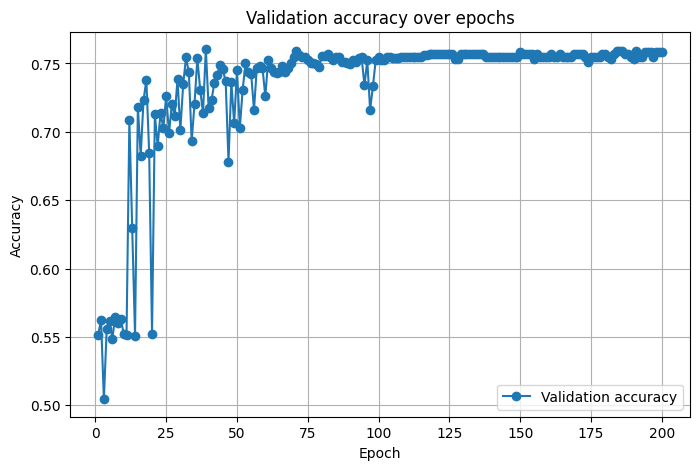

In [68]:
import matplotlib.pyplot as plt

epochs = range(1, len(running_val_acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, running_val_acc, marker='o', label="Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy over epochs")
plt.grid(True)
plt.legend()
plt.show()



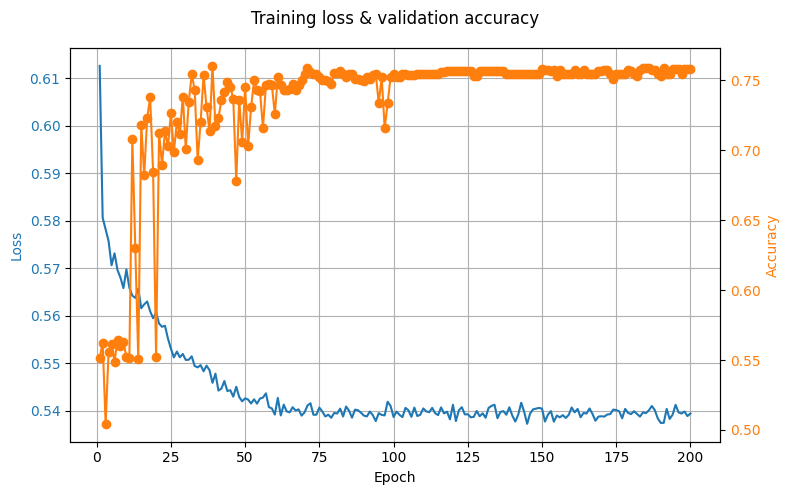

In [69]:
/home/stefan/finn/notebooks/end2end_example/cnn-dizeratiefig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(epochs, running_loss, color="tab:blue", label="Training loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(epochs, running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
ax2.set_ylabel("Accuracy", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.suptitle("Training loss & validation accuracy")
fig.tight_layout()
plt.show()

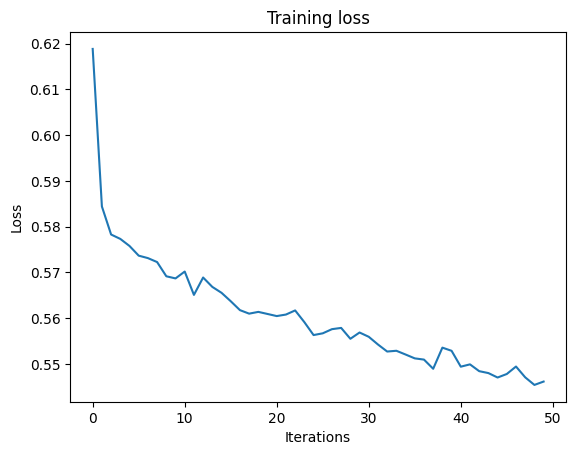

In [18]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
# display_loss_plot(loss_per_epoch)


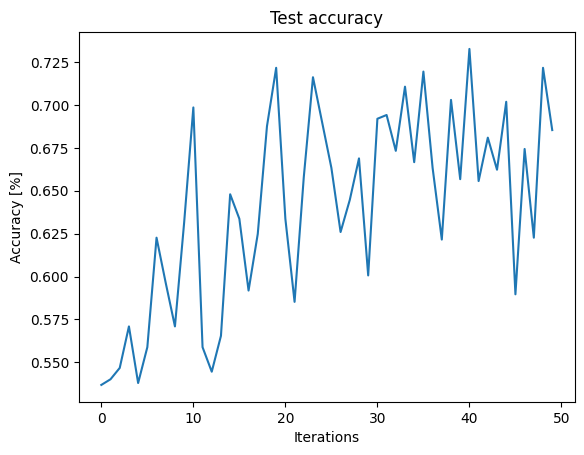

In [19]:
# acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
# display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")


In [ ]:
# Save and preparation for 2nd notebook part

In [26]:
# Save the Brevitas model to disk (self-trained driver drowsiness CNN)
state_dict_path = os.path.join(model_dir, "state_dict_drowsy_cnn_self_trained.pth")
print(state_dict_path)
torch.save(model.state_dict(), state_dict_path)
print("Saved self-trained CNN state_dict to:", state_dict_path)



/home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/state_dict_drowsy_cnn_self_trained.pth
Saved self-trained CNN state_dict to: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/state_dict_drowsy_cnn_self_trained.pth


In [27]:
import os
import torch

# Make sure the model is on CPU before loading a pretrained state_dict
model = model.cpu()

# Load self-trained CNN weights
state_dict_path = os.path.join(model_dir, "state_dict_drowsy_cnn_self_trained.pth")
trained_state_dict = torch.load(state_dict_path, map_location="cpu")

model.load_state_dict(trained_state_dict, strict=False)
print("Loaded self-trained CNN weights from:", state_dict_path)



Loaded self-trained CNN weights from: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/state_dict_drowsy_cnn_self_trained.pth


In [27]:
# # Move the model back to its target device
# model.to(device)

# # Test for accuracy
# test_acc = test(model, test_quantized_loader)
# print("Test accuracy after reloading state_dict: %.2f%%" % (100.0 * test_acc))


Test accuracy after reloading state_dict: 53.18%


In [28]:
# Move the model to CPU before export
model = model.cpu()
print("Model moved to CPU for export.")


Model moved to CPU for export.


In [29]:
from copy import deepcopy

# For this CNN we don't need any weight surgery, but we keep a copy to mimic structure
modified_model = deepcopy(model)
print("Created modified_model as a deepcopy of the trained driver drowsiness CNN.")


Created modified_model as a deepcopy of the trained driver drowsiness CNN.


In [30]:
# For the CNN, we can export the model directly without a special wrapper.
model_for_export = modified_model
model_for_export.to(device)
print("model_for_export is set to modified_model (driver drowsiness CNN).")


model_for_export is set to modified_model (driver drowsiness CNN).


In [33]:
# Optional: verify that model_for_export still performs correctly
# test_acc = test(model_for_export.to(device), test_quantized_loader)
# print("Test accuracy of model_for_export: %.2f%%" % (100.0 * test_acc))


Test accuracy of model_for_export: 53.18%


In [31]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

ready_model_filename = os.path.join(model_dir, "drowsy-cnn-ready.onnx")
input_shape = (1, 3, 128, 128) 

# create a random input tensor with the right shape
input_a = np.random.randn(*input_shape).astype(np.float32)
input_t = torch.from_numpy(input_a)

# Move to CPU before export
model_for_export = model_for_export.cpu()

# Export to ONNX (QONNX)
export_qonnx(
    model_for_export,
    export_path=ready_model_filename,
    input_t=input_t
)

# clean-up
qonnx_cleanup(ready_model_filename, out_file=ready_model_filename)

# Wrap with ModelWrapper and convert to FINN-ONNX
model_onnx = ModelWrapper(ready_model_filename)
model_onnx = model_onnx.transform(ConvertQONNXtoFINN())
model_onnx.save(ready_model_filename)

print("Model saved to %s" % ready_model_filename)


Model saved to /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/drowsy-cnn-ready.onnx


/home/stefan/finn/deps/qonnx/src/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 14. Thus the transformation may fail or return incomplete results.
  warnings.warn(


In [32]:
from finn.util.visualization import showInNetron

showInNetron(ready_model_filename)


Serving '/home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/drowsy-cnn-ready.onnx' at http://0.0.0.0:8081


In [33]:
import os
import numpy as np
import torch

# Recreate the CNN model and load the trained weights
# (DriverDrowsinessQuantCNN, weight_bit_width, act_bit_width, num_classes, device, model_dir
#  must be defined earlier in this notebook, same as before.)

state_dict_path = os.path.join(model_dir, "state_dict_drowsy_cnn_self_trained.pth")

cnn_model = SmallKerasLikeQuantCNN(
    num_classes=num_classes,
    w_bit=weight_bit_width,
    a_bit=act_bit_width,
    input_height=input_h,
    input_width=input_w,
).to(device)

cnn_model.load_state_dict(torch.load(state_dict_path, map_location=device), strict=False)
cnn_model.eval()

num_samples_to_save = 128   # or any number you like

all_inputs = []
all_labels = []
all_logits = []

saved = 0

with torch.no_grad():
    for images, labels in test_quantized_loader:  # DDD test loader
        if saved >= num_samples_to_save:
            break

        images = images.to(device)
        outputs = cnn_model(images)  # (batch, num_classes)

        for i in range(images.size(0)):
            if saved >= num_samples_to_save:
                break
            # images[i]: shape (3, 96, 96)
            all_inputs.append(images[i].cpu().numpy())
            all_labels.append(int(labels[i].item()))
            all_logits.append(outputs[i].cpu().numpy())
            saved += 1

all_inputs = np.stack(all_inputs, axis=0)          # (N, 3, 96, 96)
all_labels = np.array(all_labels, dtype=np.int64)  # (N,)
all_logits = np.stack(all_logits, axis=0)          # (N, num_classes)

npz_path = os.path.join(model_dir, "drowsy_cnn_testset.npz")
np.savez(
    npz_path,
    inputs=all_inputs,
    labels=all_labels,
    logits=all_logits
)

print("Saved testset for verification to:", npz_path)
print("  inputs shape:", all_inputs.shape)
print("  labels shape:", all_labels.shape)
print("  logits shape:", all_logits.shape)


Saved testset for verification to: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie/drowsy_cnn_testset.npz
  inputs shape: (128, 3, 128, 128)
  labels shape: (128,)
  logits shape: (128, 2)


In [ ]:
# GIT PART

In [5]:
git init 

SyntaxError: invalid syntax (3214540565.py, line 1)